In [164]:
%matplotlib inline
import numpy as np
import bayesian_pdes as bpdes
from scipy import stats
import matplotlib.pyplot as plt
import mcmc
import sympy as sp
%load_ext mcmc
%mcmc notebook

The mcmc extension is already loaded. To reload it, use:
  %reload_ext mcmc


# Sheet Parameters

In [165]:
# important helpers!
def cart2pol(points):
    x = points[:,0]
    y = points[:,1]
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return np.column_stack([rho, phi])

def pol2cart(points):
    rho = points[:,0]
    phi = points[:,1]
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return np.column_stack([x, y])

def plot_circle(x, y, values, cmap=None):
    plt.tripcolor(x.ravel(), y.ravel(), values.ravel(), cmap=cmap)
    plt.colorbar()
    plt.legend()
    plt.axis('scaled')
    plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1);

In [166]:
stim_current = 1 # current which we are stimulating with
# code for setting up the stim pattern
stim_pattern = np.zeros((7,8))
for i in xrange(7):
    stim_pattern[i,0] = 1
    stim_pattern[i, i+1] = -1
stim_pattern = stim_pattern*stim_current

# Set Up

In [167]:
from bayesian_pdes.problems import eit

In [168]:
s_x, s_xbar, s_y, s_ybar = sp.symbols('x,xbar,y,ybar')
a, a_x, a_y = sp.symbols('a,a_x,a_y')
a_bar, a_x_bar, a_y_bar = sp.symbols('abar,a_xbar,a_ybar')
s_length_scale, s_variance = sp.symbols('l,sigma')
kernel = s_variance*sp.exp(-((s_x - s_xbar)**2 + (s_y-s_ybar)**2) / (2.*s_length_scale**2))
symbols = [[s_x, s_y, a, a_x, a_y], [s_xbar, s_ybar, a_bar, a_x_bar, a_y_bar], [s_length_scale, s_variance]]

Use:
\begin{align*}
    \nabla \cdot (\exp(a)\nabla u) &= \nabla \exp(a) \cdot \nabla u + \exp(a) \nabla^2 u \\
    &= \exp(a) \left( \nabla a \cdot \nabla u + \nabla^2 u \right) \\
    &= \exp(a) \left( a_x u_x + a_y u_y + u_{xx} + u_{yy} \right)
\end{align*}
and:
\begin{align*}
    \exp(a) \nabla u \cdot n &= \exp(a) (x u_x + y u_y)
\end{align*}
for the special case of a unit circular domain centered at the origin.

In [169]:
def A(k):
    return sp.exp(a)*(k.diff(s_x,s_x) + k.diff(s_y,s_y) + k.diff(s_x)*a_x + k.diff(s_y)*a_y)
def A_bar(k):
    return sp.exp(a_bar)*(k.diff(s_xbar,s_xbar) + k.diff(s_ybar,s_ybar) + k.diff(s_xbar)*a_x_bar + k.diff(s_ybar)*a_y_bar)
def B(k):
    return sp.exp(a)*(k.diff(s_x)*s_x + k.diff(s_y)*s_y)
def B_bar(k):
    return sp.exp(a_bar)*(k.diff(s_xbar)*s_xbar + k.diff(s_ybar)*s_ybar)

In [170]:
op_system = bpdes.operator_compilation.sympy_gram.compile_sympy(
    [A, B], [A_bar, B_bar],
    kernel,
    symbols,
    parallel=True
)

## Define the collocation grid

In [171]:
r = 1.0 # todo: just assume a unit radius, is this okay?
n_in_shell = 10

In [172]:
def construct_shell(radii):
    r_spacing = radii[1] - radii[0]
    coords = [np.array([[0.,0.]])]
    for r in radii:
        # at each 'shell' we want a roughly equal number of theta around the diameter.
        # each theta should be about r_spacing apart
        n_theta = np.round(2*np.pi*r / r_spacing)
        thetas = np.linspace(0, 2*np.pi, n_theta+1)[:-1]
        x = np.cos(thetas)
        y = np.sin(thetas)
        coords.append(r*np.c_[x,y])
    coords = np.concatenate(coords)
    return coords


In [173]:
shell_radii = np.linspace(0, r, n_in_shell)[1:-1]
design_int = construct_shell(shell_radii)

In [174]:
n_bdy = 64
bdy_theta = np.linspace(0, 2*np.pi, n_bdy+1)
design_bdy = pol2cart(np.c_[np.ones(n_bdy), bdy_theta[:-1]]) 

# define the mapping from boundary collocation point to sensor
bdy_sensor_skip = 8
sensor_ixs = np.arange(0, len(design_bdy), bdy_sensor_skip)
is_sensor_flags = np.in1d(np.arange(len(design_bdy)), sensor_ixs)

sensor_xy = design_bdy[is_sensor_flags]
non_sensor_xy = design_bdy[~is_sensor_flags]
print('{} sensors'.format(len(sensor_xy)))
print('{} non-sensors'.format(len(non_sensor_xy)))

8 sensors
56 non-sensors


In [175]:
# for now we impose the BC only at the sensor locations and impose the interior condition at non-sensor bdy points
modified_design_int = np.row_stack([design_int, non_sensor_xy])
modified_design_bdy = sensor_xy

In [176]:
full_design = np.row_stack([modified_design_int, modified_design_bdy])
len(full_design)

291

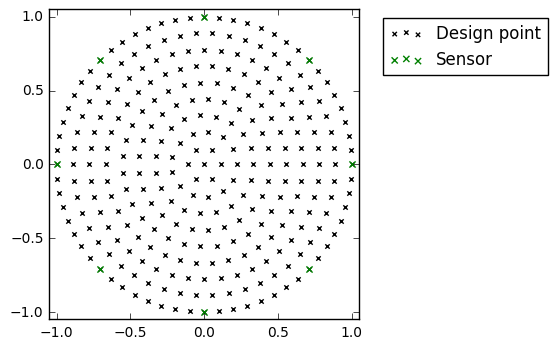

In [177]:
# plot design points
plt.figure(figsize=(4,4))
plt.scatter(design_int[:,0], design_int[:,1], marker='x', color='black', s=10)
plt.scatter(design_bdy[:,0], design_bdy[:,1], marker='x', color='black', s=10, label='Design point')
plt.scatter(sensor_xy[:,0], sensor_xy[:,1], marker='x', color='green', label='Sensor')
plt.xlim(-r*1.05,r*1.05);plt.ylim(-r*1.05,r*1.05)
plt.legend(loc=2, bbox_to_anchor=(1.05,1))

In [178]:
def theta_to_a(theta, sz_int, sz_bdy):
    kappa_int = theta[:sz_int]
    kappa_bdy = theta[sz_int:sz_int+sz_bdy]
    grad_kappa_x = theta[sz_int+sz_bdy:2*sz_int+sz_bdy]
    grad_kappa_y = theta[2*sz_int+sz_bdy:]
    return kappa_int, kappa_bdy, grad_kappa_x, grad_kappa_y

## Generate Data

In [179]:
# todo: choose this in a more principled way
length_scale = 0.2
kernel_variance = 0.01
fun_args = np.array([length_scale, kernel_variance])

In [180]:
def construct_posterior(theta, debug=False):
    a_int, a_bdy, a_x, a_y = theta_to_a(theta,
                                        modified_design_int.shape[0], 
                                        modified_design_bdy.shape[0]
                                       )
    
    augmented_int = np.column_stack([modified_design_int, a_int, a_x, a_y])
    augmented_bdy = np.column_stack([modified_design_bdy, a_bdy, np.nan*np.zeros((a_bdy.shape[0], 2))])
    obs = [
        (augmented_int, None),
        (augmented_bdy, None)
    ]
    posterior = bpdes.collocate(
        op_system.operators,
        op_system.operators_bar,
        obs,
        op_system,
        fun_args,
        inverter='np'
    )
    return posterior

In [181]:
def ball_function(locations, center, size):
    return np.log(1 + np.exp(-((locations-center)**2).sum(axis=1) / size**2))
def grad_ball_function(locations, center, size):
    grad_a = -2*(locations-center) / size**2 * np.exp(-((locations-center)**2).sum(axis=1) / size**2)[:,None]
    return grad_a / (1 + np.exp(-((locations-center)**2).sum(axis=1) / size**2)[:,None])
def field_function(int_points, bdy_points, center, size):
    u_int = ball_function(int_points, center, size)
    u_bdy = ball_function(bdy_points, center, size)
    grad_function = grad_ball_function(int_points, center, size)
    return np.concatenate([u_int, u_bdy, grad_function[:,0], grad_function[:,1]])

In [182]:
center, size = (np.array([[0,0]]), 0.4)
test_theta = field_function(modified_design_int, modified_design_bdy, center, size)
field = ball_function(full_design, center, size)


In [183]:
posterior = construct_posterior(test_theta)
dummy_obs_xy = np.column_stack([sensor_xy[1:], np.empty((sensor_xy.shape[0] - 1, 3))])
mu_mult, Sigma = posterior.no_obs_posterior(dummy_obs_xy)
rhs_int = np.zeros((len(modified_design_int), 1))
all_obs = []
for stim in stim_pattern:
    rhs = np.row_stack([rhs_int, stim[:,None]])
    obs = np.dot(mu_mult, rhs)
    all_obs.append(obs)
all_obs = np.column_stack(all_obs).T

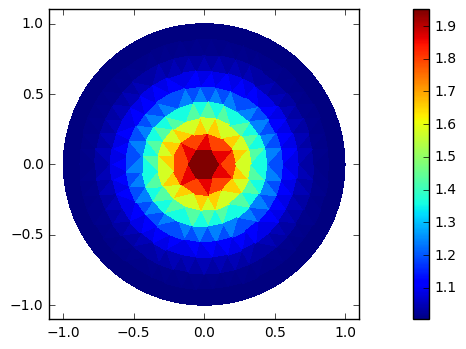

In [184]:
import os
data_name = 'centered_blob'

dest = os.path.join('dummy_data', data_name)
if not os.path.exists(dest):
    os.mkdir(dest)
np.save(os.path.join(dest, 'theta.npy'), test_theta)
np.save(os.path.join(dest, 'obs.npy'), all_obs)
fig = plot_circle(full_design[:,0], full_design[:,1], np.exp(field))
plt.savefig(os.path.join(dest, 'field.pdf'))

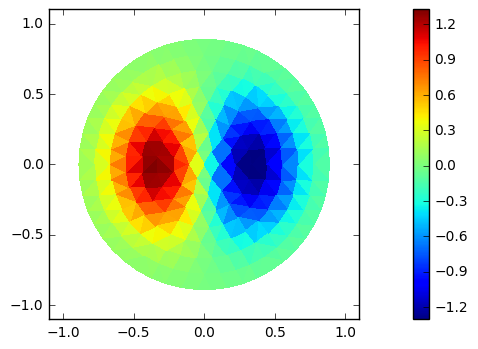

In [185]:
plot_circle(design_int[:,0], design_int[:,1], grad_ball_function(design_int, center, size)[:,0])

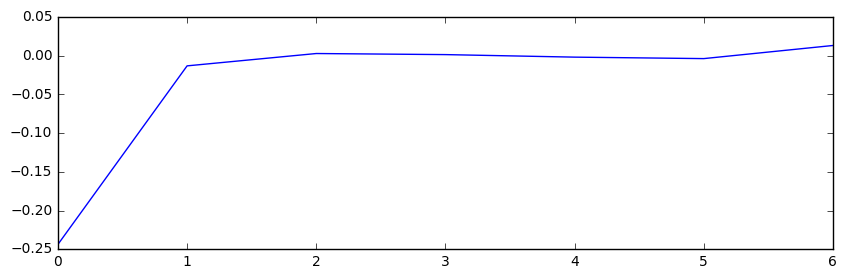

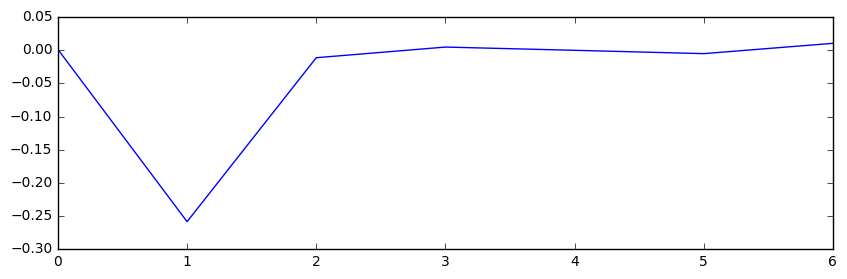

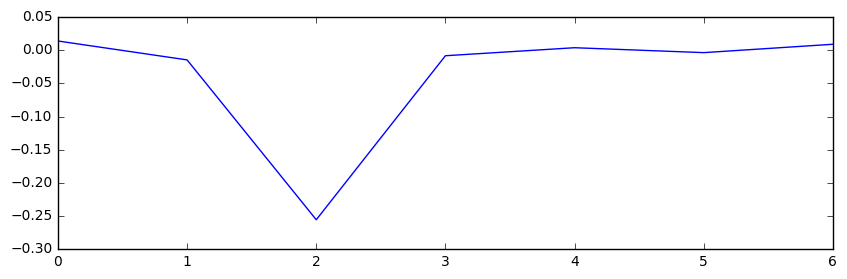

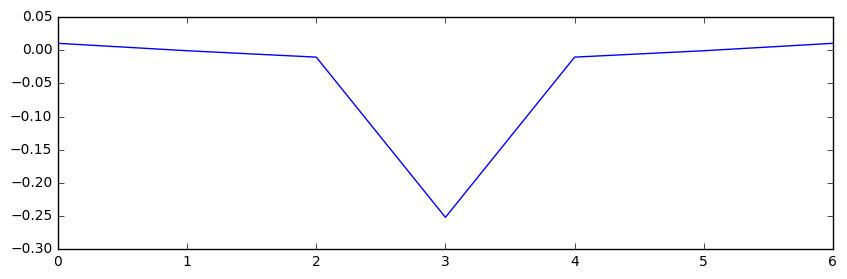

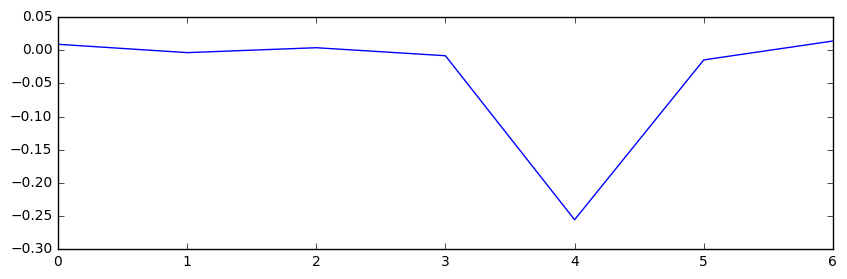

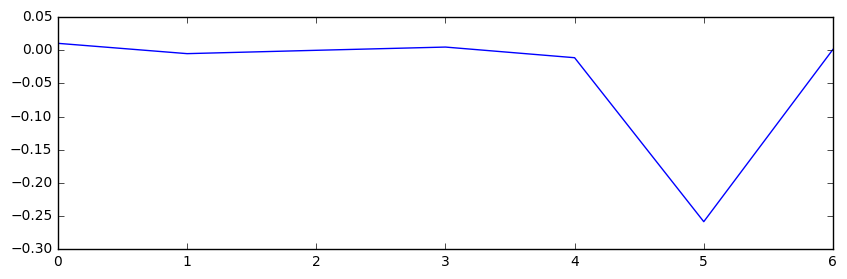

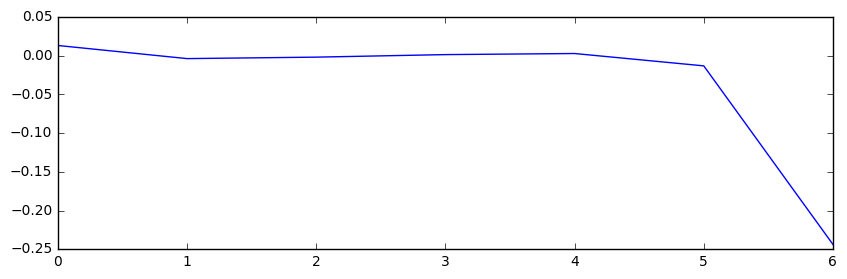

In [186]:
for o in all_obs:
    plt.figure(figsize=(10,3))
    plt.plot(o)